**Wymagane pakiety:**
- `matplotlib`

# Inicjalizacja

In [226]:
from enum import Enum
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["lines.marker"] = ""
plt.rcParams["lines.markersize"] = 5

# Funkcje pomocnicze

In [227]:
EPSILON = 10 ** -10

def det3(p0, p1, p2):
    return p0[0] * p1[1] + p1[0] * p2[1] + p2[0] * p0[1] - p2[0] * p1[1] - p1[0] * p0[1] - p0[0] * p2[1]

def circleDet3(a, b, c, d):
    ax, ay = a
    bx, by = b
    cx, cy = c
    dx, dy = d
    
    m = [
        [ax - dx, ay - dy, (ax - dx) ** 2 + (ay - dy) ** 2],
        [bx - dx, by - dy, (bx - dx) ** 2 + (by - dy) ** 2],
        [cx - dx, cy - dy, (cx - dx) ** 2 + (cy - dy) ** 2]
    ]
    
    return m[0][0] * m[1][1] * m[2][2] \
           + m[1][0] * m[2][1] * m[0][2] \
           + m[2][0] * m[0][1] * m[1][2] \
           - m[2][0] * m[1][1] * m[0][2] \
           - m[1][0] * m[0][1] * m[2][2] \
           - m[0][0] * m[2][1] * m[1][2]

In [228]:
class Point:
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
        self.triangles = {}
        self.isArbL = False
        self.isArbR = False
        self.isStart = False
    
    def addTriangle(self, triangle):
        connectedWith = triangle.points - {self}
        
        for point in connectedWith:
            if point in self.triangles:
                self.triangles[point].add(triangle)
            else:
                self.triangles[point] = {triangle}
        
    def removeTriangle(self, triangle):
        connectedWith = triangle.points - {self}
        
        for point in connectedWith:
            self.triangles[point].remove(triangle)
            
            if len(self.triangles[point]) == 0:
                del self.triangles[point]
                
    def isArb(self):
        return self.isArbL or self.isArbR
    
    def asPair(self):
        return (self.x, self.y)
    
    def liesIn(self, triangle):
        def onSegment(s1, s2, p):
            xi, yi = s1
            xj, yj = s2
            xk, yk = p
            
            return min(xi, xj) <= xk <= max(xi, xj) and min(yi, yj) <= yk <= max(yi, yj)
        
        for point in triangle.points:
            if point.isArb():
                return True
        
        t1, t2, t3 = [point.asPair() for point in triangle.points]
        
        p = self.asPair()
        
        d1 = Dir.getDir(t1, t2, p)
        d2 = Dir.getDir(t2, t3, p)
        d3 = Dir.getDir(t3, t1, p)
        
        if d1 == d2 == d3:
            return True
        
        if d1 == Dir.COLL and onSegment(t1, t2, p):
            return True
        if d2 == Dir.COLL and onSegment(t2, t3, p):
            return True
        if d3 == Dir.COLL and onSegment(t3, t1, p):
            return True
        
        return False
    
class Triangle:
    def __init__(self, p1, p2, p3):
        self.points = {p1, p2, p3}
        self.children = []
    
    def add(self):
        for point in self.points:
            point.addTriangle(self)
    
    def remove(self):
        for point in self.points:
            point.removeTriangle(self)
        
    def isLeaf(self):
        return len(self.children) == 0
    
class Dir(Enum):
    CW, COLL, CCW = range(-1, 2)
    
    def getDir(p0, p1, p2):
        det = det3(p0, p1, p2)

        if det < -EPSILON:
            return Dir.CW
        elif det <= EPSILON:
            return Dir.COLL
        else:
            return Dir.CCW

In [229]:
def triangleSearch(triangleTree, point):
    if point.liesIn(triangleTree):
        if triangleTree.isLeaf():
            return [triangleTree]
        else:
            result = []
            
            for triangle in triangleTree.children:
                result += triangleSearch(triangle, point)
                
            return result
    else:
        return []
    
def isLegal(p1, p2, freePoint, adjFreePoint):
    def getOrd(point):
        if point.isArbL:
            return -2
        if point.isArbR:
            return -1
        return 0
    
    if p1.isArb() and p2.isArb():
        return True
    if p1.isArb() and p2.isStart:
        return True
    if p2.isStart and p1.isArb():
        return True
    
    if p1.isArb() or p2.isArb() or freePoint.isArb() or adjFreePoint.isArb():
        return min(getOrd(freePoint), getOrd(adjFreePoint)) < min(getOrd(p1), getOrd(p2))
    else:
        if Dir.getDir(p1.asPair(), p2.asPair(), freePoint.asPair()) == Dir.CW:
            p1, p2 = p2, p1
        
        return circleDet3(p1.asPair(), p2.asPair(), freePoint.asPair(), adjFreePoint.asPair()) < -EPSILON
    
def legalizeEdge(triangle, freePoint):
    p1, p2 = triangle.points - {freePoint}
    for adjTriangle in p1.triangles[p2]:
        if adjTriangle != triangle:
            adjFreePoint = (adjTriangle.points - {p1, p2}).pop()

            if not isLegal(p1, p2, freePoint, adjFreePoint):
                triangle.remove()
                adjTriangle.remove()

                newTriangle1 = Triangle(p1, freePoint, adjFreePoint)
                newTriangle2 = Triangle(p2, freePoint, adjFreePoint)

                newTriangle1.add()
                newTriangle2.add()
                
                newTriangles = [newTriangle1, newTriangle2]

                triangle.children += newTriangles
                adjTriangle.children += newTriangles

                legalizeEdge(newTriangle1, freePoint)
                legalizeEdge(newTriangle2, freePoint)
                
            break


def delaunayTriangulation(points):
    points = points.copy()
    
    a = Point(0, 100)
    b = Point(-100, -100)
    c = Point(100, -100)
    
#     arbL = Point()
#     arbL.isArbL = True
#     arbR = Point()
#     arbR.isArbR = True
    
#     startX, startY = points.pop(points.index(max(points, key=lambda point: (point[1], point[0]))))
#     start = Point(startX, startY)
#     start.isStart = True
    
#     triangleTree = Triangle(start, arbL, arbR)
    triangleTree = Triangle(a, b, c)
    
    triangleTree.add()
    
    fst = None
    
    random.shuffle(points)
    
    for x, y in points:
        newPoint = Point(x, y)
        triangles = list(set(triangleSearch(triangleTree, newPoint)))
        
        if fst is None:
            fst = newPoint
        
        if len(triangles) == 1:
            toSplit = triangles[0]
            
            toSplit.remove()
                
            newTrianglesPoints = list(toSplit.points)
            newTriangles = []
            for i in range(0, 2):
                for j in range(i + 1, 3):
                    p1 = newTrianglesPoints[i]
                    p2 = newTrianglesPoints[j]

                    newTriangles.append(Triangle(p1, p2, newPoint))
                        
            for triangle in newTriangles:
                triangle.add()
                        
            toSplit.children += newTriangles
            
            for triangle in newTriangles:
                legalizeEdge(triangle, newPoint)
        elif len(triangles) == 2:
            toSplit1, toSplit2 = triangles[0:2]
            
            toSplit1.remove()
            toSplit2.remove()
            splitEdge = toSplit1.points & toSplit2.points
            
            s1, s2 = splitEdge
            freePoint1 = (toSplit1.points - splitEdge).pop()
            freePoint2 = (toSplit2.points - splitEdge).pop()
            
            newTriangles1 = []
            newTriangles1.append(Triangle(newPoint, freePoint1, s1))
            newTriangles1.append(Triangle(newPoint, freePoint1, s2))
            
            newTriangles2 = []
            newTriangles2.append(Triangle(newPoint, freePoint2, s1))
            newTriangles2.append(Triangle(newPoint, freePoint2, s2))
            
            toSplit1.children += newTriangles1
            toSplit2.children += newTriangles2
            
            newTriangles = newTriangles1 + newTriangles2
            
            for triangle in newTriangles:
                triangle.add()
                
            for triangle in newTriangles:
                legalizeEdge(triangle, newPoint)
        else:
            raise Exception("this shouldn't happen")
            
    triangleSetsToRemove = []
    triangleSetsToRemove += a.triangles.values()
    triangleSetsToRemove += b.triangles.values()
    triangleSetsToRemove += c.triangles.values()
#     trianglesToRemove += arbL.triangles.values()
#     trianglesToRemove += arbR.triangles.values()

    trianglesToRemove = set()
    for triangleSet in triangleSetsToRemove:
        trianglesToRemove |= triangleSet
        
    for triangle in trianglesToRemove:
        triangle.remove()
        
    visited = set()
    def dfsWalk(triangle):
        if triangle not in visited:
            visited.add(triangle)
            for point in triangle.points:
                for triangleSet in point.triangles.values():
                    for triangle in triangleSet:
                        dfsWalk(triangle)
    
#     dfsWalk(triangleSearch(triangleTree, fst)[0])
    dfsWalk(next(iter(next(iter(fst.triangles.values())))))
    return visited
    

In [230]:
def randPoint():
    return (random.uniform(0, 10), random.uniform(0, 10))

l = [randPoint() for _ in range(100)]

187


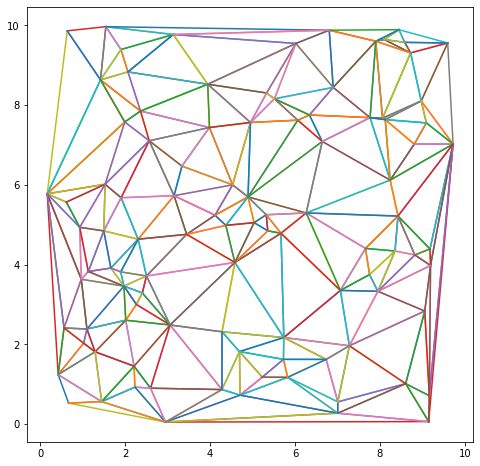

In [238]:

tg = delaunayTriangulation(l)
print(len(tg))
for tr in tg:
    p1, p2, p3 = [point.asPair() for point in tr.points]
    
    p1x, p1y = p1
    p2x, p2y = p2
    p3x, p3y = p3
    
    plt.plot([p1x, p2x], [p1y, p2y])
    plt.plot([p1x, p3x], [p1y, p3y])
    plt.plot([p2x, p3x], [p2y, p3y])